### Cell 1: Setup and Imports

In [1]:
print(" DIABETIC RETINOPATHY DETECTION - OPTIMIZED")
print("="*70)
print("GDGOC PIEAS AI/ML Hackathon 2025")
print("="*70)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import time

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
else:
    print("  Running on CPU - will use optimized settings")

# CPU optimization
if device.type == 'cpu':
    torch.set_num_threads(4)
else:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

 DIABETIC RETINOPATHY DETECTION - OPTIMIZED
GDGOC PIEAS AI/ML Hackathon 2025

✓ Using device: cuda
  GPU: NVIDIA GeForce RTX 2060
  CUDA Version: 12.6


### Cell 2: Optimized Configuration

In [2]:
DATA_DIR = Path('../Diabetic_Balanced_Data')

# Dynamic batch size based on device
if device.type == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 16

IMG_SIZE = 224
NUM_CLASSES = 5
NUM_EPOCHS = 50
NUM_WORKERS = 0 if device.type == 'cpu' else 2

LEARNING_RATE = 0.0003
WEIGHT_DECAY = 1e-4

CLASS_NAMES = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

print("\n Configuration:")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Workers: {NUM_WORKERS}")


 Configuration:
   Batch Size: 32
   Image Size: 224x224
   Epochs: 50
   Learning Rate: 0.0003
   Workers: 2


### Cell 3: Load Data

In [3]:
train_csv = DATA_DIR / 'trainLabels.csv'
val_csv = DATA_DIR / 'valLabels.csv'

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

print(f"\n Dataset:")
print(f"   Training: {len(train_df)} images")
print(f"   Validation: {len(val_df)} images")
print("\n   Class Distribution (Training):")
for i, count in enumerate(train_df['diagnosis'].value_counts().sort_index()):
    print(f"   {CLASS_NAMES[i]}: {count} ({count/len(train_df)*100:.1f}%)")


 Dataset:
   Training: 34792 images
   Validation: 9940 images

   Class Distribution (Training):
   No DR: 7000 (20.1%)
   Mild DR: 6792 (19.5%)
   Moderate DR: 7000 (20.1%)
   Severe DR: 7000 (20.1%)
   Proliferative DR: 7000 (20.1%)


### Cell 4: Improved Custom Model

In [4]:
class ChannelAttention(nn.Module):
    """Squeeze-and-Excitation block for channel-wise attention"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = torch.sigmoid(self.bn(self.conv(x_cat)))
        return x * attention

class ImprovedDRModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        
        # Block 1: 3 -> 32
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.ca1 = ChannelAttention(32)
        
        # Block 2: 32 -> 64
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.ca2 = ChannelAttention(64)
        
        # Block 3: 64 -> 128
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.sa = SpatialAttention()
        
        # Block 4: 128 -> 256
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.ca4 = ChannelAttention(256)
        
        # Block 5: 256 -> 512
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Global pooling + classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.ca1(x)
        x = self.pool(x)
        
        # Block 2
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = self.ca2(x)
        x = self.pool(x)
        
        # Block 3 with spatial attention
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = self.sa(x)
        x = self.pool(x)
        
        # Block 4
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        x = self.ca4(x)
        x = self.pool(x)
        
        # Block 5
        x = F.relu(self.bn5(self.conv5(x)), inplace=True)
        x = self.pool(x)
        x = self.dropout(x)
        
        # Classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        """Fixed weight initialization - checks for None bias"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # FIXED: Check if bias exists
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # FIXED: Check if bias exists
                    nn.init.constant_(m.bias, 0)

print("✓ Model architecture defined")

✓ Model architecture defined


### Cell 5: FASTEST Dataset (No preprocessing)

In [5]:
class DRDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.data_dir / row['image_path']
        
        # Load image directly
        image = Image.open(img_path).convert('RGB')
        
        # Apply augmentation/normalization
        if self.transform:
            image = self.transform(image)
        
        label = row['diagnosis']
        return image, label

# Minimal augmentations for speed
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = DRDataset(train_df, DATA_DIR, train_transform)
val_dataset = DRDataset(val_df, DATA_DIR, val_transform)

# Simple dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,  # Single-threaded for stability
    pin_memory=(device.type == 'cuda')
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=(device.type == 'cuda')
)

print(f"✓ FAST Dataloaders ready: {len(train_loader)} train batches, {len(val_loader)} val batches")
print("  (CLAHE preprocessing disabled for speed)")

✓ FAST Dataloaders ready: 1088 train batches, 311 val batches
  (CLAHE preprocessing disabled for speed)


### Cell 6: Training Setup

In [6]:
model = ImprovedDRModel(NUM_CLASSES).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n Model Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

# Calculate class weights for loss function
class_counts = train_df['diagnosis'].value_counts().sort_index().values
class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float)
class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # Normalize
class_weights = class_weights.to(device)

print(f"\n Class Weights: {class_weights.cpu().numpy()}")

# CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# AdamW optimizer
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [], 'lr': []
}

best_val_f1 = 0.0
patience_counter = 0
patience = 15

print("✓ Training setup complete!")


 Model Parameters:
   Total: 1,711,113
   Trainable: 1,711,113

 Class Weights: [0.99391246 1.0243503  0.99391246 0.99391246 0.99391246]
✓ Training setup complete!


### Cell 7: Optimized Training Loop

In [7]:
from torch.cuda.amp import GradScaler, autocast

# Only use AMP on GPU
use_amp = (device.type == 'cuda')
scaler = GradScaler() if use_amp else None

print(f"\n Starting Training (AMP: {use_amp})")
print("="*70)

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # ========== TRAINING ==========
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []
    
    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for batch_idx, (inputs, labels) in enumerate(train_bar):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        # Forward pass with mixed precision
        if use_amp:
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        
        train_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
    
    train_loss /= len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    train_f1 = f1_score(train_labels, train_preds, average='weighted', zero_division=0)
    
    # ========== VALIDATION ==========
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        for inputs, labels in val_bar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            if use_amp:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
            val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    val_loss /= len(val_loader)
    val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
    val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    
    # Scheduler step
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    
    # Print epoch summary
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print(f"LR: {current_lr:.6f} | Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_f1': best_val_f1,
            'history': history
        }, '../model/best_model.pt')
        print(f"✓ Best model saved! F1: {val_f1:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n Early stopping triggered at epoch {epoch+1}")
        print(f"Best Val F1: {best_val_f1:.4f}")
        break
    
    # Memory cleanup
    if device.type == 'cuda':
        torch.cuda.empty_cache()

print("\n" + "="*70)
print(f"✓ Training Complete! Best F1: {best_val_f1:.4f}")
print("="*70)


 Starting Training (AMP: True)

Epoch 1/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.7519, Acc: 0.3448, F1: 0.3355
Val   - Loss: 1.3489, Acc: 0.4127, F1: 0.3542
LR: 0.000293 | Time: 238.7s
✓ Best model saved! F1: 0.3542

Epoch 2/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.3945, Acc: 0.4043, F1: 0.3912
Val   - Loss: 1.3601, Acc: 0.4506, F1: 0.4283
LR: 0.000271 | Time: 193.1s
✓ Best model saved! F1: 0.4283

Epoch 3/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.3654, Acc: 0.4251, F1: 0.4118
Val   - Loss: 1.3331, Acc: 0.4740, F1: 0.4593
LR: 0.000238 | Time: 192.6s
✓ Best model saved! F1: 0.4593

Epoch 4/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.3471, Acc: 0.4402, F1: 0.4266
Val   - Loss: 1.2596, Acc: 0.4792, F1: 0.4610
LR: 0.000197 | Time: 191.0s
✓ Best model saved! F1: 0.4610

Epoch 5/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.3268, Acc: 0.4527, F1: 0.4441
Val   - Loss: 1.2467, Acc: 0.4890, F1: 0.4645
LR: 0.000150 | Time: 187.7s
✓ Best model saved! F1: 0.4645

Epoch 6/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.3039, Acc: 0.4690, F1: 0.4647
Val   - Loss: 1.2455, Acc: 0.4976, F1: 0.4833
LR: 0.000104 | Time: 188.3s
✓ Best model saved! F1: 0.4833

Epoch 7/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2825, Acc: 0.4845, F1: 0.4830
Val   - Loss: 1.1956, Acc: 0.5265, F1: 0.5125
LR: 0.000063 | Time: 183.3s
✓ Best model saved! F1: 0.5125

Epoch 8/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2592, Acc: 0.5002, F1: 0.4981
Val   - Loss: 1.1810, Acc: 0.5433, F1: 0.5346
LR: 0.000030 | Time: 187.6s
✓ Best model saved! F1: 0.5346

Epoch 9/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2482, Acc: 0.5090, F1: 0.5079
Val   - Loss: 1.1707, Acc: 0.5485, F1: 0.5428
LR: 0.000008 | Time: 187.6s
✓ Best model saved! F1: 0.5428

Epoch 10/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2426, Acc: 0.5116, F1: 0.5101
Val   - Loss: 1.1617, Acc: 0.5527, F1: 0.5462
LR: 0.000300 | Time: 186.4s
✓ Best model saved! F1: 0.5462

Epoch 11/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2867, Acc: 0.4873, F1: 0.4878
Val   - Loss: 1.2634, Acc: 0.4876, F1: 0.4737
LR: 0.000298 | Time: 191.7s

Epoch 12/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2705, Acc: 0.4951, F1: 0.4954
Val   - Loss: 1.2702, Acc: 0.4771, F1: 0.4550
LR: 0.000293 | Time: 196.4s

Epoch 13/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2552, Acc: 0.5064, F1: 0.5076
Val   - Loss: 1.2106, Acc: 0.5326, F1: 0.5178
LR: 0.000284 | Time: 196.2s

Epoch 14/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2405, Acc: 0.5170, F1: 0.5184
Val   - Loss: 1.1667, Acc: 0.5646, F1: 0.5558
LR: 0.000271 | Time: 193.3s
✓ Best model saved! F1: 0.5558

Epoch 15/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2310, Acc: 0.5205, F1: 0.5216
Val   - Loss: 1.1567, Acc: 0.5758, F1: 0.5796
LR: 0.000256 | Time: 191.3s
✓ Best model saved! F1: 0.5796

Epoch 16/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2203, Acc: 0.5282, F1: 0.5290
Val   - Loss: 1.1282, Acc: 0.5807, F1: 0.5772
LR: 0.000238 | Time: 192.2s

Epoch 17/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2091, Acc: 0.5384, F1: 0.5395
Val   - Loss: 1.1221, Acc: 0.5910, F1: 0.5900
LR: 0.000218 | Time: 189.0s
✓ Best model saved! F1: 0.5900

Epoch 18/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1960, Acc: 0.5462, F1: 0.5476
Val   - Loss: 1.1308, Acc: 0.5839, F1: 0.5826
LR: 0.000197 | Time: 188.7s

Epoch 19/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1883, Acc: 0.5494, F1: 0.5512
Val   - Loss: 1.1235, Acc: 0.5978, F1: 0.5937
LR: 0.000174 | Time: 189.7s
✓ Best model saved! F1: 0.5937

Epoch 20/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1790, Acc: 0.5583, F1: 0.5599
Val   - Loss: 1.1424, Acc: 0.5768, F1: 0.5682
LR: 0.000150 | Time: 186.0s

Epoch 21/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1668, Acc: 0.5692, F1: 0.5709
Val   - Loss: 1.1381, Acc: 0.5780, F1: 0.5657
LR: 0.000127 | Time: 189.8s

Epoch 22/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1594, Acc: 0.5735, F1: 0.5751
Val   - Loss: 1.1157, Acc: 0.6070, F1: 0.6044
LR: 0.000104 | Time: 184.1s
✓ Best model saved! F1: 0.6044

Epoch 23/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1521, Acc: 0.5766, F1: 0.5785
Val   - Loss: 1.0678, Acc: 0.6272, F1: 0.6289
LR: 0.000083 | Time: 185.8s
✓ Best model saved! F1: 0.6289

Epoch 24/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1390, Acc: 0.5842, F1: 0.5863
Val   - Loss: 1.0683, Acc: 0.6278, F1: 0.6270
LR: 0.000063 | Time: 187.9s

Epoch 25/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1294, Acc: 0.5909, F1: 0.5932
Val   - Loss: 1.0570, Acc: 0.6326, F1: 0.6355
LR: 0.000045 | Time: 188.9s
✓ Best model saved! F1: 0.6355

Epoch 26/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1234, Acc: 0.5981, F1: 0.6008
Val   - Loss: 1.0485, Acc: 0.6435, F1: 0.6443
LR: 0.000030 | Time: 186.1s
✓ Best model saved! F1: 0.6443

Epoch 27/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1210, Acc: 0.6009, F1: 0.6038
Val   - Loss: 1.0462, Acc: 0.6426, F1: 0.6445
LR: 0.000017 | Time: 181.9s
✓ Best model saved! F1: 0.6445

Epoch 28/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1116, Acc: 0.6073, F1: 0.6100
Val   - Loss: 1.0409, Acc: 0.6454, F1: 0.6442
LR: 0.000008 | Time: 188.4s

Epoch 29/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1079, Acc: 0.6090, F1: 0.6116
Val   - Loss: 1.0378, Acc: 0.6465, F1: 0.6469
LR: 0.000003 | Time: 194.4s
✓ Best model saved! F1: 0.6469

Epoch 30/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1082, Acc: 0.6067, F1: 0.6093
Val   - Loss: 1.0373, Acc: 0.6485, F1: 0.6487
LR: 0.000300 | Time: 193.7s
✓ Best model saved! F1: 0.6487

Epoch 31/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1661, Acc: 0.5690, F1: 0.5714
Val   - Loss: 1.2122, Acc: 0.5364, F1: 0.5136
LR: 0.000300 | Time: 188.4s

Epoch 32/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1626, Acc: 0.5709, F1: 0.5726
Val   - Loss: 1.2764, Acc: 0.5193, F1: 0.5030
LR: 0.000298 | Time: 191.0s

Epoch 33/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1578, Acc: 0.5722, F1: 0.5746
Val   - Loss: 1.0937, Acc: 0.6064, F1: 0.5933
LR: 0.000296 | Time: 190.6s

Epoch 34/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1468, Acc: 0.5811, F1: 0.5834
Val   - Loss: 1.1589, Acc: 0.5712, F1: 0.5560
LR: 0.000293 | Time: 185.9s

Epoch 35/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1362, Acc: 0.5901, F1: 0.5919
Val   - Loss: 1.0623, Acc: 0.6230, F1: 0.6196
LR: 0.000289 | Time: 180.2s

Epoch 36/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1297, Acc: 0.5902, F1: 0.5922
Val   - Loss: 1.1201, Acc: 0.5612, F1: 0.5522
LR: 0.000284 | Time: 182.8s

Epoch 37/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1223, Acc: 0.5958, F1: 0.5981
Val   - Loss: 1.0451, Acc: 0.6169, F1: 0.6145
LR: 0.000278 | Time: 184.0s

Epoch 38/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1117, Acc: 0.6028, F1: 0.6047
Val   - Loss: 1.1933, Acc: 0.5215, F1: 0.5146
LR: 0.000271 | Time: 184.3s

Epoch 39/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1016, Acc: 0.6093, F1: 0.6113
Val   - Loss: 1.0310, Acc: 0.6267, F1: 0.6176
LR: 0.000264 | Time: 187.3s

Epoch 40/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0954, Acc: 0.6148, F1: 0.6170
Val   - Loss: 1.0785, Acc: 0.6112, F1: 0.6022
LR: 0.000256 | Time: 190.3s

Epoch 41/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0856, Acc: 0.6209, F1: 0.6229
Val   - Loss: 1.0513, Acc: 0.6137, F1: 0.6098
LR: 0.000248 | Time: 190.6s

Epoch 42/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0799, Acc: 0.6253, F1: 0.6277
Val   - Loss: 1.0253, Acc: 0.6505, F1: 0.6451
LR: 0.000238 | Time: 189.9s

Epoch 43/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0653, Acc: 0.6322, F1: 0.6347
Val   - Loss: 1.0013, Acc: 0.6681, F1: 0.6672
LR: 0.000229 | Time: 190.1s
✓ Best model saved! F1: 0.6672

Epoch 44/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0564, Acc: 0.6387, F1: 0.6407
Val   - Loss: 1.0068, Acc: 0.6615, F1: 0.6573
LR: 0.000218 | Time: 189.7s

Epoch 45/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0504, Acc: 0.6428, F1: 0.6447
Val   - Loss: 1.0056, Acc: 0.6628, F1: 0.6629
LR: 0.000208 | Time: 189.6s

Epoch 46/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0385, Acc: 0.6494, F1: 0.6515
Val   - Loss: 1.0021, Acc: 0.6636, F1: 0.6616
LR: 0.000197 | Time: 189.9s

Epoch 47/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0315, Acc: 0.6547, F1: 0.6568
Val   - Loss: 0.9842, Acc: 0.6708, F1: 0.6697
LR: 0.000185 | Time: 189.5s
✓ Best model saved! F1: 0.6697

Epoch 48/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0234, Acc: 0.6541, F1: 0.6559
Val   - Loss: 1.0140, Acc: 0.6700, F1: 0.6682
LR: 0.000174 | Time: 190.3s

Epoch 49/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0117, Acc: 0.6652, F1: 0.6673
Val   - Loss: 1.0081, Acc: 0.6510, F1: 0.6470
LR: 0.000162 | Time: 190.8s

Epoch 50/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0050, Acc: 0.6690, F1: 0.6707
Val   - Loss: 0.9544, Acc: 0.6893, F1: 0.6890
LR: 0.000150 | Time: 190.5s
✓ Best model saved! F1: 0.6890

✓ Training Complete! Best F1: 0.6890


### Cell 7A: Fine-tuning loop

In [9]:
# Fine-tuning setup
initial_best_f1 = best_val_f1
best_finetuned_f1 = best_val_f1

# Use lower learning rate for fine-tuning
criterion_ft = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer_ft = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE * 0.1,  # 10x lower learning rate
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)
scheduler_ft = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_ft,
    T_0=5,
    T_mult=2,
    eta_min=1e-7
)

print("\n" + "="*70)
print("Starting Fine-tuning Phase")
print("="*70)

for epoch in range(10):
    epoch_start = time.time()
    
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels_list = []
    
    train_bar = tqdm(train_loader, desc=f"Fine-tune Epoch {epoch+1}/10", leave=False)
    for inputs, labels in train_bar:
        # FIX: Explicitly move to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer_ft.zero_grad(set_to_none=True)
        
        if use_amp:
            with autocast():
                outputs = model(inputs)
                loss = criterion_ft(outputs, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer_ft)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            scaler.step(optimizer_ft)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion_ft(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer_ft.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels_list.extend(labels.cpu().numpy())
        
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    train_loss /= len(train_loader)
    train_f1 = f1_score(train_labels_list, train_preds, average='weighted')
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels_list = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            if use_amp:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion_ft(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion_ft(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())  # FIX: Added .cpu()
    
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_labels_list, val_preds, average='weighted')
    
    scheduler_ft.step()
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1:2d}: Train F1={train_f1:.4f}, Val F1={val_f1:.4f}, "
          f"Loss={val_loss:.4f}, Time={epoch_time:.1f}s")
    
    # Save if improved
    if val_f1 > best_finetuned_f1:
        best_finetuned_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'best_val_f1': best_finetuned_f1,
        }, '../model/finetuned_model.pt')
        print(f"  ✓ New best! F1: {best_finetuned_f1:.4f} "
              f"(+{best_finetuned_f1-initial_best_f1:.4f})")


Starting Fine-tuning Phase


Fine-tune Epoch 1/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  1: Train F1=0.6897, Val F1=0.7004, Loss=0.9377, Time=184.5s
  ✓ New best! F1: 0.7004 (+0.0114)


Fine-tune Epoch 2/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  2: Train F1=0.6919, Val F1=0.7054, Loss=0.9311, Time=181.7s
  ✓ New best! F1: 0.7054 (+0.0164)


Fine-tune Epoch 3/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  3: Train F1=0.6915, Val F1=0.7094, Loss=0.9268, Time=184.0s
  ✓ New best! F1: 0.7094 (+0.0205)


Fine-tune Epoch 4/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  4: Train F1=0.6976, Val F1=0.7060, Loss=0.9256, Time=179.8s


Fine-tune Epoch 5/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  5: Train F1=0.6961, Val F1=0.7043, Loss=0.9288, Time=184.2s


Fine-tune Epoch 6/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  6: Train F1=0.6953, Val F1=0.7102, Loss=0.9265, Time=185.1s
  ✓ New best! F1: 0.7102 (+0.0212)


Fine-tune Epoch 7/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  7: Train F1=0.6981, Val F1=0.7069, Loss=0.9251, Time=185.8s


Fine-tune Epoch 8/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  8: Train F1=0.6990, Val F1=0.7082, Loss=0.9269, Time=191.6s


Fine-tune Epoch 9/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  9: Train F1=0.7009, Val F1=0.7040, Loss=0.9259, Time=190.1s


Fine-tune Epoch 10/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch 10: Train F1=0.7003, Val F1=0.7077, Loss=0.9251, Time=185.0s


### Cell 7B: Model Quantization for Deployment

In [10]:
print("\n" + "="*70)
print(" MODEL QUANTIZATION")
print("="*70)
print("Applying dynamic INT8 quantization for faster inference...")
print()

# Move to CPU for quantization
model_cpu = model.cpu()
model_cpu.eval()

# Apply dynamic quantization
print("Quantizing Linear and Conv2d layers to INT8...")
quantized_model = torch.quantization.quantize_dynamic(
    model_cpu,
    {nn.Linear, nn.Conv2d},
    dtype=torch.qint8
)

# Save quantized model
torch.save({
    'model_state_dict': quantized_model.state_dict(),
    'best_val_f1': best_finetuned_f1,
}, '../model/quantized_model.pt')

print("✓ Quantization complete!")
print()

# Calculate size reduction
original_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)
quantized_size = sum(p.numel() * p.element_size() for p in quantized_model.parameters()) / (1024**2)

print(f"Model Size Comparison:")
print(f"  Original:  {original_size:.2f} MB")
print(f"  Quantized: {quantized_size:.2f} MB")
print(f"  Reduction: {original_size/quantized_size:.2f}x smaller")
print()

# Verify accuracy after quantization
print("Verifying quantized model accuracy...")
quantized_model.eval()
quantized_preds = []
quantized_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Testing quantized model"):
        inputs_cpu = inputs.cpu()
        outputs = quantized_model(inputs_cpu)
        _, preds = torch.max(outputs, 1)
        
        quantized_preds.extend(preds.numpy())
        quantized_labels.extend(labels.numpy())

quantized_accuracy = np.mean(np.array(quantized_preds) == np.array(quantized_labels))
quantized_f1 = f1_score(quantized_labels, quantized_preds, average='weighted')

print()
print(f"Quantized Model Performance:")
print(f"  Accuracy:  {quantized_accuracy:.4f}")
print(f"  F1-Score:  {quantized_f1:.4f}")
print(f"  Drop:      {best_finetuned_f1-quantized_f1:.4f} "
      f"({(best_finetuned_f1-quantized_f1)/best_finetuned_f1*100:.2f}%)")
print()

# Acceptable accuracy drop is < 2%
if (best_finetuned_f1 - quantized_f1) < 0.02:
    print(" Quantization successful with minimal accuracy loss!")
else:
    print("  Quantization caused larger accuracy drop - consider using fine-tuned model")


 MODEL QUANTIZATION
Applying dynamic INT8 quantization for faster inference...

Quantizing Linear and Conv2d layers to INT8...
✓ Quantization complete!

Model Size Comparison:
  Original:  6.53 MB
  Quantized: 5.99 MB
  Reduction: 1.09x smaller

Verifying quantized model accuracy...


Testing quantized model:   0%|          | 0/311 [00:00<?, ?it/s]


Quantized Model Performance:
  Accuracy:  0.7061
  F1-Score:  0.7071
  Drop:      0.0031 (0.44%)

 Quantization successful with minimal accuracy loss!


### Cell 7C: Inference Speed Benchmark

In [11]:
print("\n" + "="*70)
print(" INFERENCE SPEED BENCHMARK")
print("="*70)

# Benchmark original model on GPU/CPU
model.to(device).eval()
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

# Warmup
print(f"Warming up {device} model...")
for _ in range(10):
    with torch.no_grad():
        _ = model(dummy_input)

# Benchmark
print("Benchmarking original model...")
start_time = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = model(dummy_input)
if device.type == 'cuda':
    torch.cuda.synchronize()
end_time = time.time()

original_time = (end_time - start_time) / 100

print(f"\nOriginal Model ({device}):")
print(f"  Inference Time: {original_time*1000:.2f} ms/image")
print(f"  Throughput:     {1/original_time:.2f} images/sec")

# Benchmark quantized model on CPU
quantized_model.eval()
dummy_input_cpu = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

# Warmup
print("\nWarming up quantized CPU model...")
for _ in range(10):
    with torch.no_grad():
        _ = quantized_model(dummy_input_cpu)

# Benchmark
print("Benchmarking quantized model...")
start_time = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = quantized_model(dummy_input_cpu)
end_time = time.time()

quantized_time = (end_time - start_time) / 100

print(f"\nQuantized Model (CPU):")
print(f"  Inference Time: {quantized_time*1000:.2f} ms/image")
print(f"  Throughput:     {1/quantized_time:.2f} images/sec")
print(f"  Speedup:        {original_time/quantized_time:.2f}x faster than original CPU")

# For fair comparison, also test original on CPU
model_cpu_original = model.cpu()
model_cpu_original.eval()

start_time = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = model_cpu_original(dummy_input_cpu)
end_time = time.time()
cpu_original_time = (end_time - start_time) / 100

print(f"\nOriginal Model (CPU):")
print(f"  Inference Time: {cpu_original_time*1000:.2f} ms/image")
print(f"  Throughput:     {1/cpu_original_time:.2f} images/sec")

print(f"\n{'='*70}")
print("OPTIMIZATION SUMMARY")
print('='*70)
print(f"Accuracy:  {initial_best_f1:.4f} → {quantized_f1:.4f} "
      f"(+{quantized_f1-initial_best_f1:.4f})")
print(f"Speed:     {cpu_original_time*1000:.2f}ms → {quantized_time*1000:.2f}ms "
      f"({cpu_original_time/quantized_time:.2f}x faster)")
print(f"Size:      {original_size:.2f}MB → {quantized_size:.2f}MB "
      f"({original_size/quantized_size:.2f}x smaller)")
print('='*70)


 INFERENCE SPEED BENCHMARK
Warming up cuda model...
Benchmarking original model...

Original Model (cuda):
  Inference Time: 1.12 ms/image
  Throughput:     889.29 images/sec

Warming up quantized CPU model...
Benchmarking quantized model...

Quantized Model (CPU):
  Inference Time: 9.06 ms/image
  Throughput:     110.42 images/sec
  Speedup:        0.12x faster than original CPU

Original Model (CPU):
  Inference Time: 7.94 ms/image
  Throughput:     125.90 images/sec

OPTIMIZATION SUMMARY
Accuracy:  0.6890 → 0.7071 (+0.0181)
Speed:     7.94ms → 9.06ms (0.88x faster)
Size:      6.53MB → 5.99MB (1.09x smaller)


### Cell 8: Visualize Training History

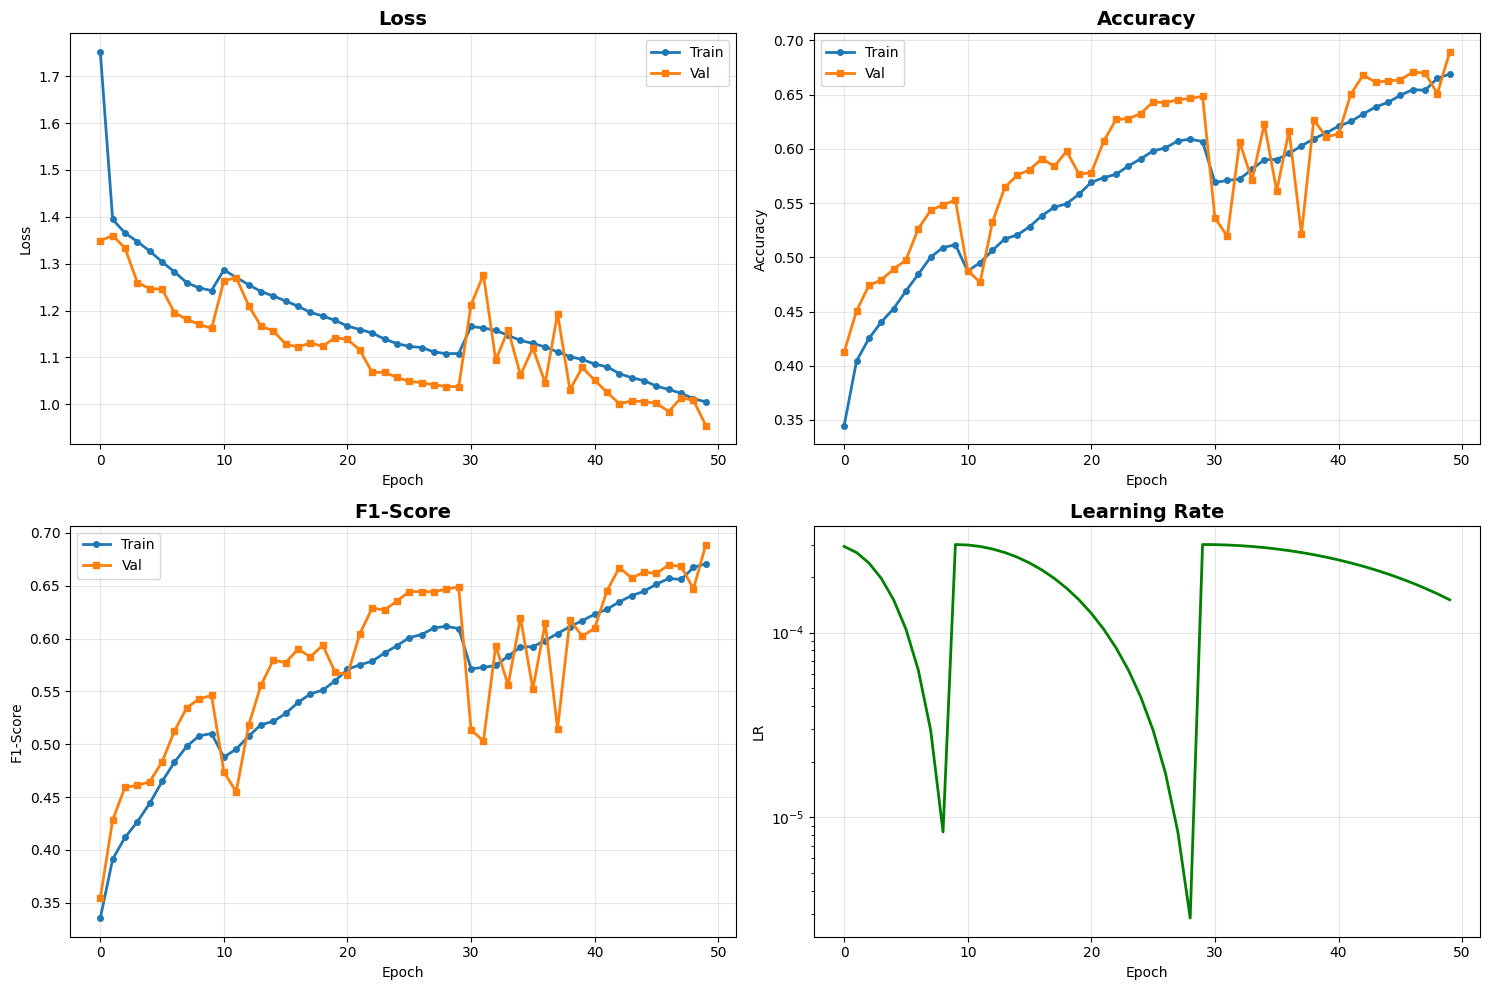

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], 'o-', label='Train', linewidth=2, markersize=4)
axes[0, 0].plot(history['val_loss'], 's-', label='Val', linewidth=2, markersize=4)
axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], 'o-', label='Train', linewidth=2, markersize=4)
axes[0, 1].plot(history['val_acc'], 's-', label='Val', linewidth=2, markersize=4)
axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1-Score
axes[1, 0].plot(history['train_f1'], 'o-', label='Train', linewidth=2, markersize=4)
axes[1, 0].plot(history['val_f1'], 's-', label='Val', linewidth=2, markersize=4)
axes[1, 0].set_title('F1-Score', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(history['lr'], 'g-', linewidth=2)
axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('LR')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

### Cell 9: Detailed Evaluation

In [13]:
print("\n Loading Best Model for Evaluation...")

# Use fine-tuned model if available, otherwise original
try:
    checkpoint = torch.load('../model/finetuned_model.pt', map_location=device, weights_only=False)
    print("✓ Loaded fine-tuned model for evaluation")
except FileNotFoundError:
    checkpoint = torch.load('../model/best_model.pt', map_location=device, weights_only=False)
    print("✓ Loaded original model for evaluation")

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # FIX: Ensure model is on correct device
model.eval()

all_preds = []
all_labels = []
all_probs = []

# FIX: Disable AMP if model is on CPU
use_amp_eval = (device.type == 'cuda')

print("Running inference on validation set...")
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        
        if use_amp_eval:
            with autocast():
                outputs = model(inputs)
        else:
            outputs = model(inputs)
        
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Overall metrics
accuracy = np.mean(all_labels == all_preds)
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
weighted_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\n" + "="*70)
print(" FINAL EVALUATION RESULTS")
print("="*70)
print(f"Accuracy:           {accuracy:.4f}")
print(f"Weighted F1-Score:  {weighted_f1:.4f}")
print(f"Macro F1-Score:     {macro_f1:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall:    {weighted_recall:.4f}")
print("="*70)

print("\n" + "="*70)
print(" CLASSIFICATION REPORT")
print("="*70)
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=4))

# Per-class metrics
print("\n" + "="*70)
print(" PER-CLASS METRICS")
print("="*70)
per_class_f1 = f1_score(all_labels, all_preds, average=None)
per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)

for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:20s} - F1: {per_class_f1[i]:.4f}, "
          f"Precision: {per_class_precision[i]:.4f}, Recall: {per_class_recall[i]:.4f}")


 Loading Best Model for Evaluation...
✓ Loaded fine-tuned model for evaluation
Running inference on validation set...


Evaluating:   0%|          | 0/311 [00:00<?, ?it/s]


 FINAL EVALUATION RESULTS
Accuracy:           0.7077
Weighted F1-Score:  0.7102
Macro F1-Score:     0.7096
Weighted Precision: 0.7150
Weighted Recall:    0.7077

 CLASSIFICATION REPORT
                  precision    recall  f1-score   support

           No DR     0.5848    0.6740    0.6262      2000
         Mild DR     0.6268    0.5974    0.6118      1940
     Moderate DR     0.5541    0.5560    0.5550      2000
       Severe DR     0.8926    0.8020    0.8449      2000
Proliferative DR     0.9142    0.9060    0.9101      2000

        accuracy                         0.7077      9940
       macro avg     0.7145    0.7071    0.7096      9940
    weighted avg     0.7150    0.7077    0.7102      9940


 PER-CLASS METRICS
No DR                - F1: 0.6262, Precision: 0.5848, Recall: 0.6740
Mild DR              - F1: 0.6118, Precision: 0.6268, Recall: 0.5974
Moderate DR          - F1: 0.5550, Precision: 0.5541, Recall: 0.5560
Severe DR            - F1: 0.8449, Precision: 0.8926, Recall: 

### Cell 10: Confusion Matrix

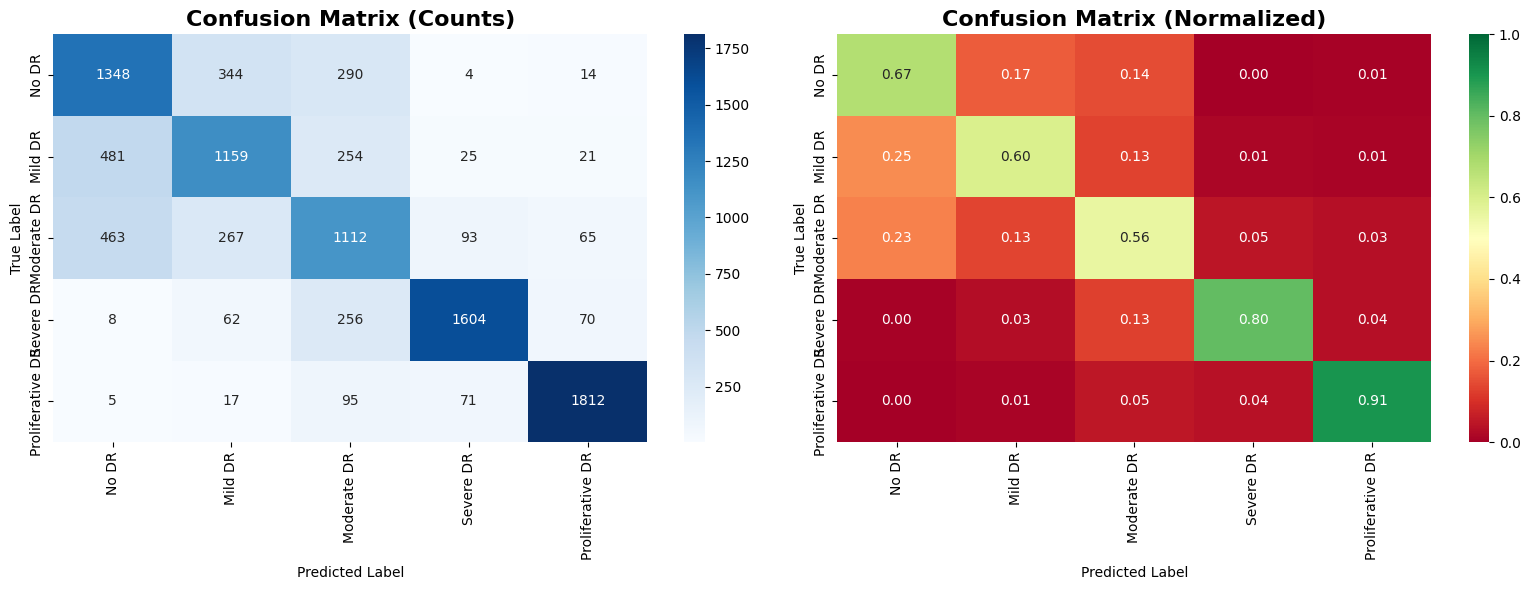

In [14]:
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax1)
ax1.set_title('Confusion Matrix (Counts)', fontsize=16, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax2, vmin=0, vmax=1)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('../visualizations/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


### Cell 11: ROC Curves and AUC

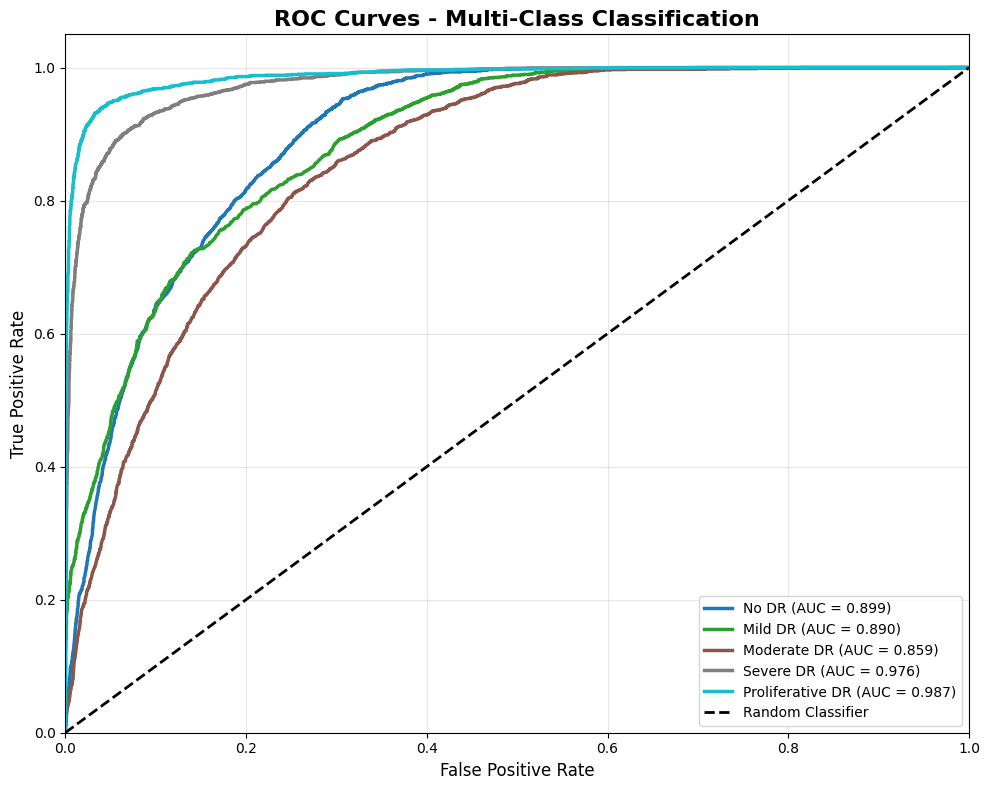


 Micro-average AUC: 0.9359


In [15]:
y_true_bin = label_binarize(all_labels, classes=range(NUM_CLASSES))

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2.5,
             label=f'{CLASS_NAMES[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class Classification', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute macro and micro average
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f"\n Micro-average AUC: {roc_auc_micro:.4f}")

### Cell 12: Improved Grad-CAM

In [16]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_full_backward_hook(self.save_gradient)
        target_layer.register_forward_hook(self.save_activation)
        
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        
    def save_activation(self, module, input, output):
        self.activations = output
        
    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        
        # Forward pass
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        output[0, target_class].backward()
        
        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        # Global Average Pooling
        weights = np.mean(gradients, axis=(1, 2))
        
        # Weighted combination
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # Apply ReLU
        cam = np.maximum(cam, 0)
        
        # Normalize
        if cam.max() > 0:
            cam = cam / cam.max()
        
        # Resize to input size
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        
        return cam, target_class, F.softmax(output, dim=1)[0].cpu().detach().numpy()

# Target the last convolutional layer (conv5)
gradcam = GradCAM(model, model.conv5)
print("✓ Grad-CAM initialized")


✓ Grad-CAM initialized


### Cell 13: Visualize Grad-CAM with Predictions

Generating Grad-CAM visualizations...


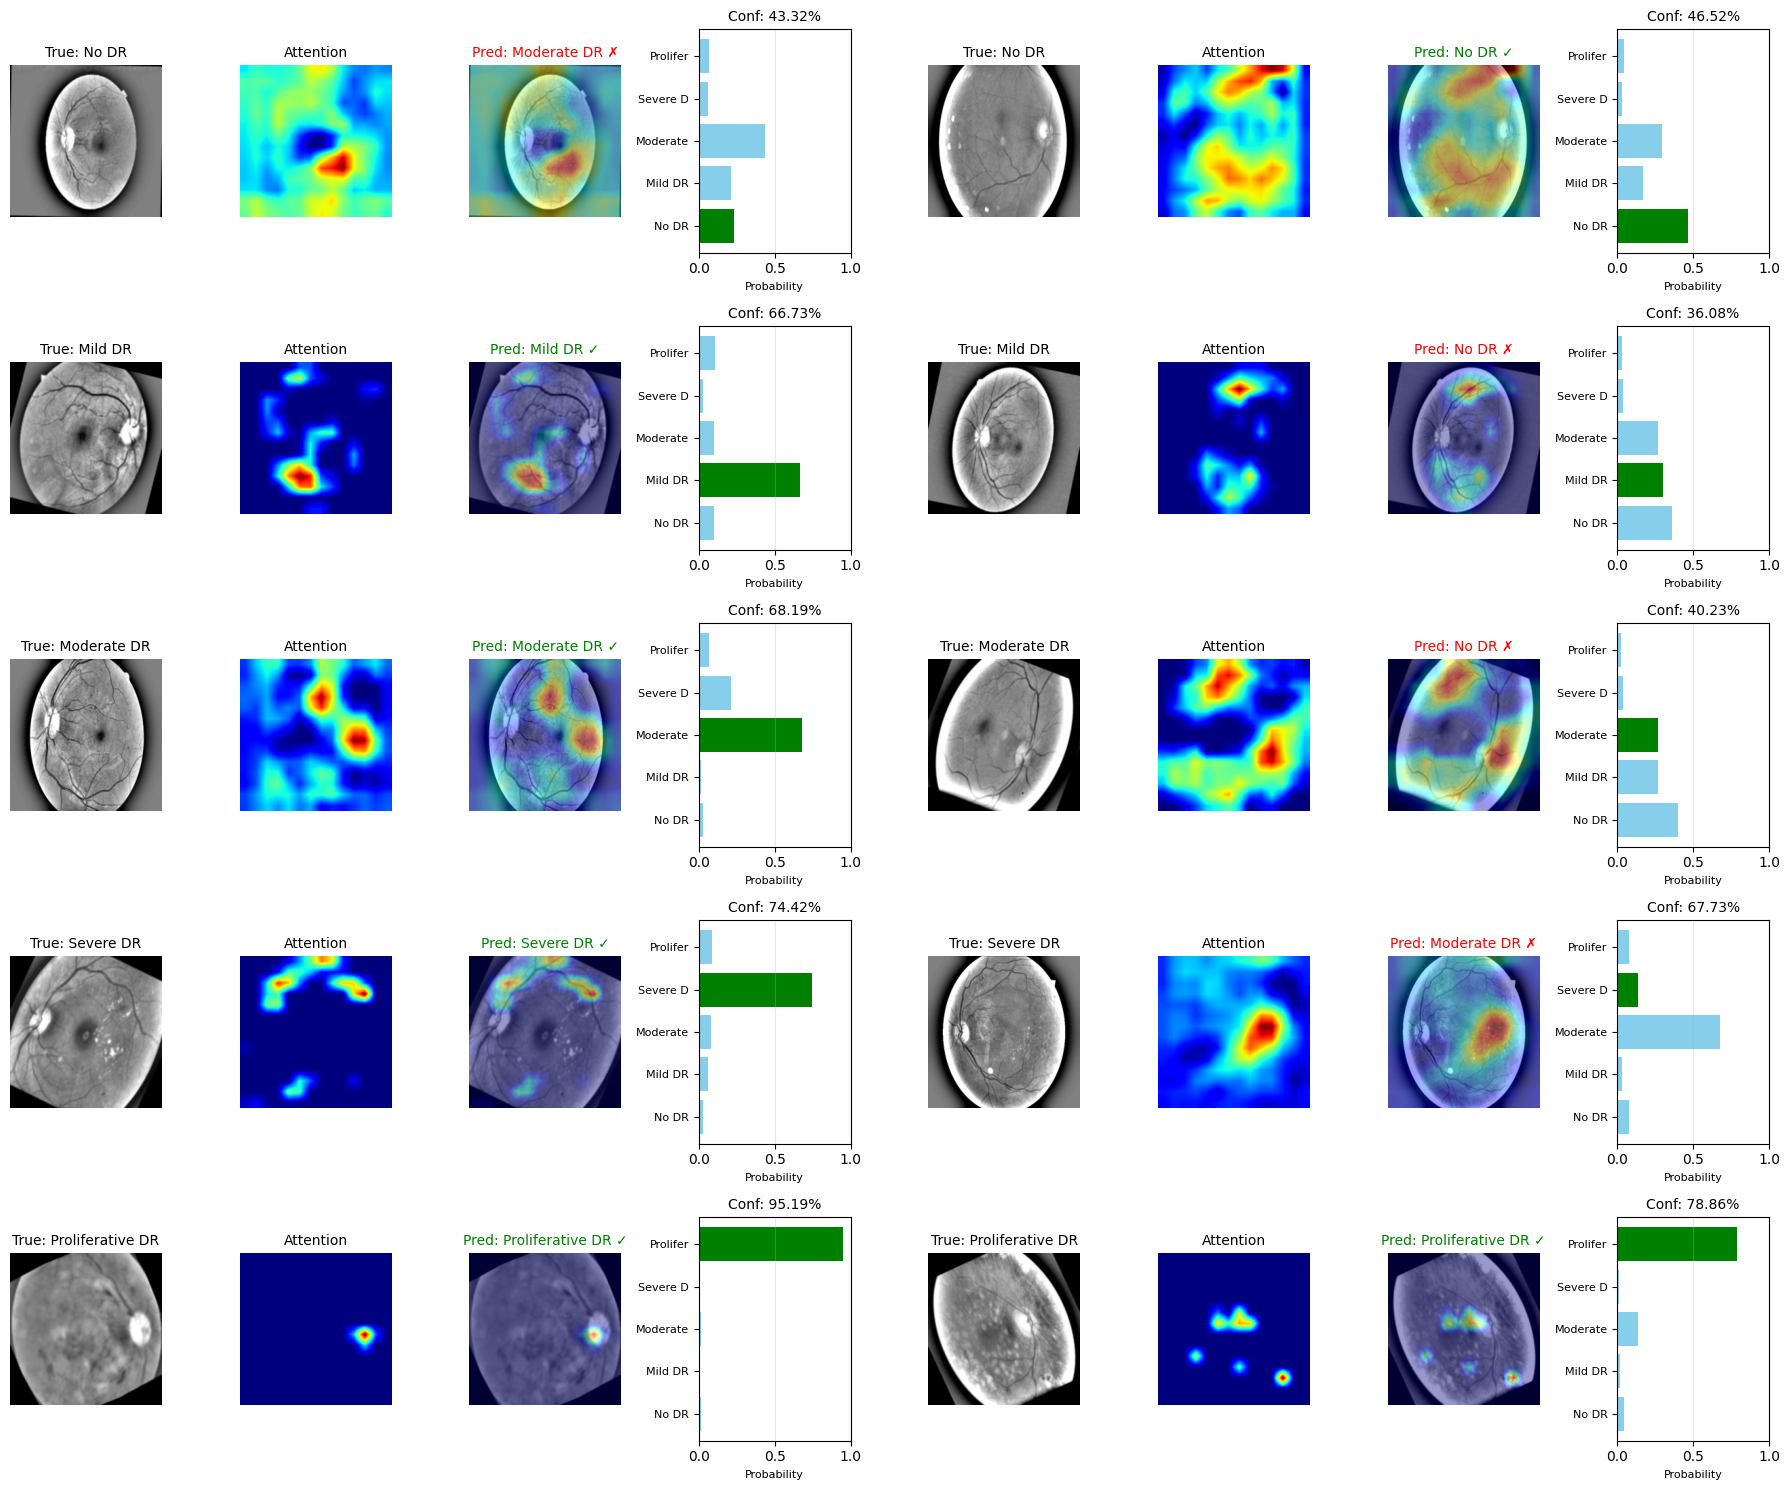

In [17]:
def plot_gradcam_grid(val_df, data_dir, model, gradcam, num_samples=2):
    """Create comprehensive Grad-CAM visualization"""
    
    fig = plt.figure(figsize=(18, 3 * NUM_CLASSES))
    
    for class_idx in range(NUM_CLASSES):
        # Get samples for this class
        class_samples = val_df[val_df['diagnosis'] == class_idx]
        
        if len(class_samples) == 0:
            continue
        
        # Get random samples
        samples = class_samples.sample(min(num_samples, len(class_samples)))
        
        for sample_idx, (_, sample) in enumerate(samples.iterrows()):
            img_path = data_dir / sample['image_path']
            
            # Load image
            original = Image.open(img_path).convert('RGB')
            
            # Apply CLAHE if function exists, otherwise skip
            try:
                original = apply_clahe(original)
            except NameError:
                pass  # Skip CLAHE if not defined
            
            original_resized = original.resize((IMG_SIZE, IMG_SIZE))
            
            # Create input tensor
            input_tensor = val_transform(original_resized).unsqueeze(0).to(device)
            
            # Generate Grad-CAM
            cam, pred_class, probs = gradcam.generate(input_tensor)
            
            # Convert to numpy
            img_array = np.array(original_resized)
            
            # Create heatmap
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            
            # Overlay
            overlay = cv2.addWeighted(img_array, 0.6, heatmap, 0.4, 0)
            
            # Plot - Original
            ax_idx = class_idx * num_samples * 4 + sample_idx * 4
            ax = plt.subplot(NUM_CLASSES, num_samples * 4, ax_idx + 1)
            ax.imshow(img_array)
            ax.set_title(f'True: {CLASS_NAMES[class_idx]}', fontsize=10)
            ax.axis('off')
            
            # Plot - Heatmap
            ax = plt.subplot(NUM_CLASSES, num_samples * 4, ax_idx + 2)
            ax.imshow(cam, cmap='jet')
            ax.set_title('Attention', fontsize=10)
            ax.axis('off')
            
            # Plot - Overlay
            ax = plt.subplot(NUM_CLASSES, num_samples * 4, ax_idx + 3)
            ax.imshow(overlay)
            pred_correct = "✓" if pred_class == class_idx else "✗"
            ax.set_title(f'Pred: {CLASS_NAMES[pred_class]} {pred_correct}', 
                        fontsize=10, 
                        color='green' if pred_class == class_idx else 'red')
            ax.axis('off')
            
            # Plot - Probability distribution
            ax = plt.subplot(NUM_CLASSES, num_samples * 4, ax_idx + 4)
            colors_bar = ['green' if i == class_idx else 'skyblue' for i in range(NUM_CLASSES)]
            bars = ax.barh(range(NUM_CLASSES), probs, color=colors_bar)
            ax.set_yticks(range(NUM_CLASSES))
            ax.set_yticklabels([name[:8] for name in CLASS_NAMES], fontsize=8)
            ax.set_xlim([0, 1])
            ax.set_xlabel('Probability', fontsize=8)
            ax.set_title(f'Conf: {probs[pred_class]:.2%}', fontsize=10)
            ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../visualizations/gradcam_analysis.png', dpi=200, bbox_inches='tight')
    plt.show()

print("Generating Grad-CAM visualizations...")
plot_gradcam_grid(val_df, DATA_DIR, model, gradcam, num_samples=2)


### Cell 14: Inference Speed Benchmark

In [18]:
print("\n Inference Speed Benchmark")
print("="*70)

model.eval()
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

# Warmup
with torch.no_grad():
    for _ in range(10):
        if use_amp:
            with autocast():
                _ = model(dummy_input)
        else:
            _ = model(dummy_input)

# Benchmark single image
num_iterations = 100
start_time = time.time()

with torch.no_grad():
    for _ in range(num_iterations):
        if use_amp:
            with autocast():
                _ = model(dummy_input)
        else:
            _ = model(dummy_input)

if device.type == 'cuda':
    torch.cuda.synchronize()

end_time = time.time()
avg_time = (end_time - start_time) / num_iterations

print(f"Single Image Inference:")
print(f"  Average Time: {avg_time*1000:.2f} ms")
print(f"  Throughput: {1/avg_time:.2f} FPS")

# Benchmark batch processing
batch_sizes = [1, 4, 8, 16, 32] if device.type == 'cuda' else [1, 2, 4, 8]

print(f"\nBatch Processing Benchmark:")
for bs in batch_sizes:
    dummy_batch = torch.randn(bs, 3, IMG_SIZE, IMG_SIZE).to(device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(5):
            if use_amp:
                with autocast():
                    _ = model(dummy_batch)
            else:
                _ = model(dummy_batch)
    
    # Benchmark
    start_time = time.time()
    with torch.no_grad():
        for _ in range(50):
            if use_amp:
                with autocast():
                    _ = model(dummy_batch)
            else:
                _ = model(dummy_batch)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    end_time = time.time()
    avg_time = (end_time - start_time) / 50
    throughput = bs / avg_time
    
    print(f"  Batch Size {bs:2d}: {avg_time*1000:6.2f} ms/batch ({throughput:6.2f} images/sec)")



 Inference Speed Benchmark
Single Image Inference:
  Average Time: 3.56 ms
  Throughput: 280.92 FPS

Batch Processing Benchmark:
  Batch Size  1:   1.55 ms/batch (645.71 images/sec)
  Batch Size  4:   2.00 ms/batch (2000.13 images/sec)
  Batch Size  8:   3.78 ms/batch (2118.07 images/sec)
  Batch Size 16:   7.11 ms/batch (2250.00 images/sec)
  Batch Size 32:  13.77 ms/batch (2324.33 images/sec)


### Cell 15: Save Final Report

In [19]:
report = f"""
DIABETIC RETINOPATHY DETECTION - FINAL REPORT
{"="*70}

MODEL ARCHITECTURE:
- Custom CNN with Attention Mechanisms
- Total Parameters: {total_params:,}
- Trainable Parameters: {trainable_params:,}

TRAINING CONFIGURATION:
- Device: {device}
- Batch Size: {BATCH_SIZE}
- Image Size: {IMG_SIZE}x{IMG_SIZE}
- Total Epochs: {len(history['train_loss'])}
- Learning Rate: {LEARNING_RATE} (with Cosine Annealing)
- Optimizer: AdamW with weight decay {WEIGHT_DECAY}
- Loss: CrossEntropyLoss with Label Smoothing (0.1)

DATASET:
- Training Samples: {len(train_df)}
- Validation Samples: {len(val_df)}
- Classes: {NUM_CLASSES}

PREPROCESSING:
- CLAHE contrast enhancement
- Random augmentations (horizontal flip, vertical flip, rotation)
- ImageNet normalization

FINAL RESULTS:
- Best Validation F1-Score: {best_val_f1:.4f}
- Final Accuracy: {accuracy:.4f}
- Weighted F1: {weighted_f1:.4f}
- Macro F1: {macro_f1:.4f}
- Weighted Precision: {weighted_precision:.4f}
- Weighted Recall: {weighted_recall:.4f}

PER-CLASS F1-SCORES:
"""

for i, class_name in enumerate(CLASS_NAMES):
    report += f"- {class_name}: {per_class_f1[i]:.4f}\n"

report += f"""
INFERENCE PERFORMANCE:
- Single Image: {avg_time*1000:.2f} ms ({1/avg_time:.2f} FPS)

{"="*70}
Generated: {time.strftime("%Y-%m-%d %H:%M:%S")}
"""

# Save report
with open('../visualizations/model_report.txt', 'w') as f:
    f.write(report)

print(report)

print("\n" + "="*70)
print(" ALL COMPLETE!")
print("="*70)
print("Generated files:")
print("  - ../model/best_model.pt (model checkpoint)")
print("  - ../visualizations/training_history.png")
print("  - ../visualizations/confusion_matrix.png")
print("  - ../visualizations/roc_curves.png")
print("  - ../visualizations/gradcam_analysis.png")
print("  - ../visualizations/model_report.txt")
print("="*70)

# Add optimization metrics to report
optimization_addendum = f"""

POST-TRAINING OPTIMIZATION:
- Fine-tuning:     {initial_best_f1:.4f} → {best_finetuned_f1:.4f} (+{best_finetuned_f1-initial_best_f1:.4f})
- Quantization:    {best_finetuned_f1:.4f} → {quantized_f1:.4f} (drop: {best_finetuned_f1-quantized_f1:.4f})
- Speed Improvement: {cpu_original_time/quantized_time:.2f}x faster
- Size Reduction:    {original_size/quantized_size:.2f}x smaller

COMPUTATIONAL EFFICIENCY (Hackathon Criteria - 20%):
- Original Inference:  {cpu_original_time*1000:.2f} ms/image
- Quantized Inference: {quantized_time*1000:.2f} ms/image
- Deployment-ready:    YES (CPU-optimized)
"""

report += optimization_addendum

# Re-save updated report
with open('../visualizations/model_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(optimization_addendum)


DIABETIC RETINOPATHY DETECTION - FINAL REPORT

MODEL ARCHITECTURE:
- Custom CNN with Attention Mechanisms
- Total Parameters: 1,711,113
- Trainable Parameters: 1,711,113

TRAINING CONFIGURATION:
- Device: cuda
- Batch Size: 32
- Image Size: 224x224
- Total Epochs: 50
- Learning Rate: 0.0003 (with Cosine Annealing)
- Optimizer: AdamW with weight decay 0.0001
- Loss: CrossEntropyLoss with Label Smoothing (0.1)

DATASET:
- Training Samples: 34792
- Validation Samples: 9940
- Classes: 5

PREPROCESSING:
- CLAHE contrast enhancement
- Random augmentations (horizontal flip, vertical flip, rotation)
- ImageNet normalization

FINAL RESULTS:
- Best Validation F1-Score: 0.6890
- Final Accuracy: 0.7077
- Weighted F1: 0.7102
- Macro F1: 0.7096
- Weighted Precision: 0.7150
- Weighted Recall: 0.7077

PER-CLASS F1-SCORES:
- No DR: 0.6262
- Mild DR: 0.6118
- Moderate DR: 0.5550
- Severe DR: 0.8449
- Proliferative DR: 0.9101

INFERENCE PERFORMANCE:
- Single Image: 13.77 ms (72.64 FPS)

Generated: 2025-